In [ ]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [25]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [26]:
data = files[b'data']
labels = files[b'labels']

In [27]:
data.shape

(10000, 3072)

In [28]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

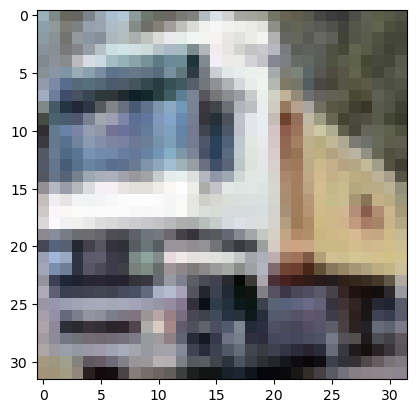

In [38]:
imshow(data[1])

In [39]:
labels[1]

9

In [40]:
classes[labels[1]]

'truck'

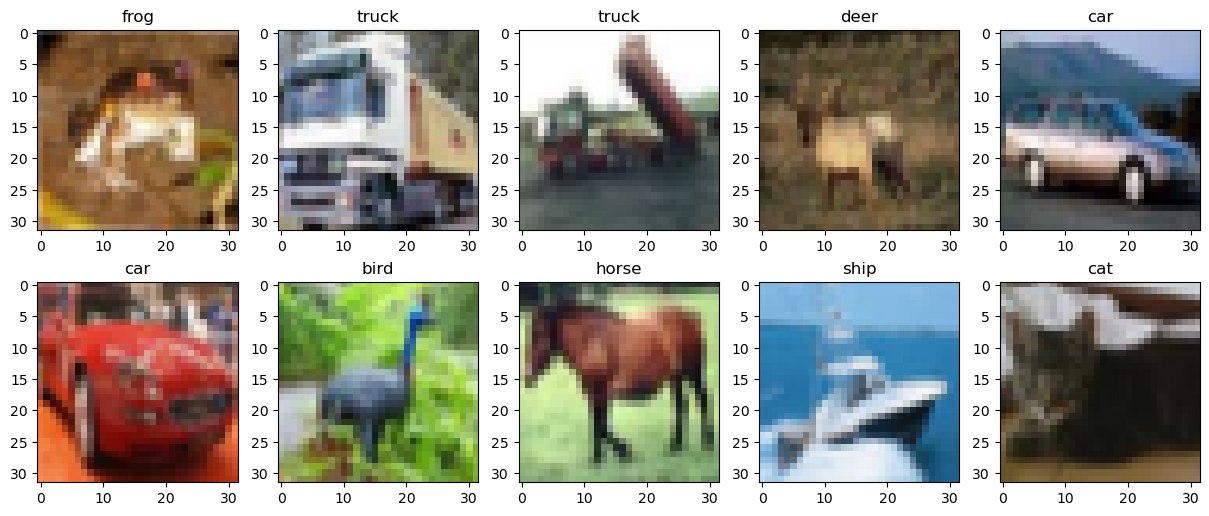

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
idx=0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

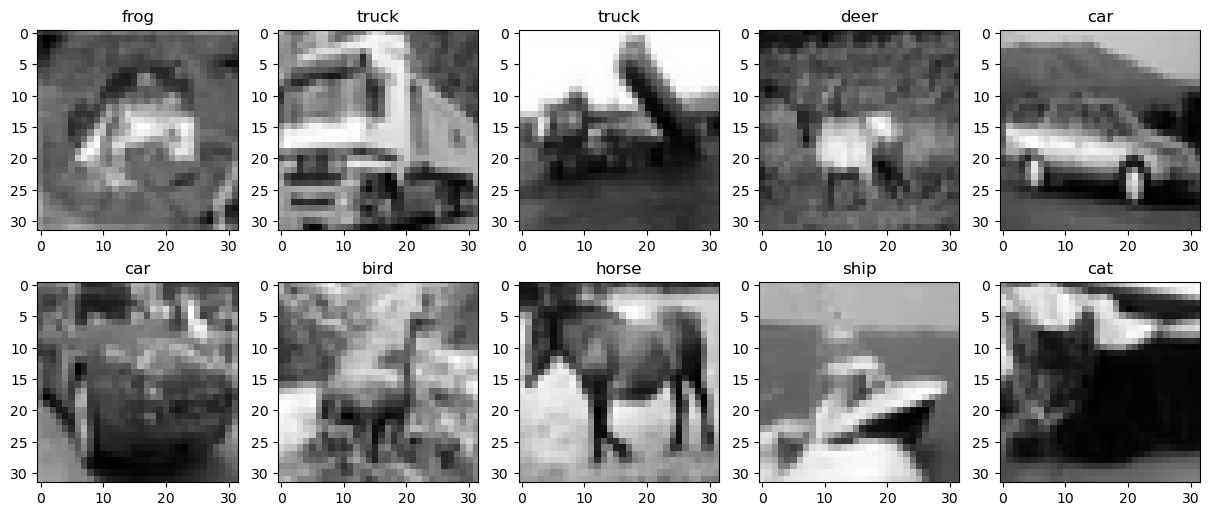

In [51]:
# convert to grayscale
data_gray = np.mean(data, axis=1)
data_gray.shape

idx = 0
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data_gray[idx], cmap='gray')
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1